In [199]:
!pip install jdatetime
!pip install jdatetime persiantools

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import jdatetime
import seaborn as sns

In [200]:
btc = yf.download("BTC-USD", start="2018-01-01", end="2024-12-30")

btc['Solar_Date'] = btc.index.to_series().apply(lambda x: jdatetime.date.fromgregorian(date=x.to_pydatetime()).strftime("%Y-%m-%d"))
btc['Weekday'] = btc.index.day_name()

btc = btc.drop(columns=['High', 'Low', 'Volume'])
btc = btc.drop(btc[btc['Weekday'].isin(['Saturday', 'Monday', 'Tuesday', 'Thursday', 'Friday'])].index)

print(btc.info())

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2018-01-03 to 2024-12-29
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, BTC-USD)  730 non-null    float64
 1   (Open, BTC-USD)   730 non-null    float64
 2   (Solar_Date, )    730 non-null    object 
 3   (Weekday, )       730 non-null    object 
dtypes: float64(2), object(2)
memory usage: 28.5+ KB
None


In [201]:
open_sun = btc[btc['Weekday'] == 'Sunday'][['Open', 'Solar_Date']]
close_wed = btc[btc['Weekday'] == 'Wednesday'][['Close', 'Solar_Date']]

open_sun.columns = ['Open', 'Solar_Date']
close_wed.columns = ['Close', 'Solar_Date']

open_sun = open_sun.sort_index()
close_wed = close_wed.sort_index()

print(open_sun.info())
print(close_wed.info())

open_sun = open_sun.copy()
open_sun['Wednesday Close'] = close_wed['Close'].reindex(open_sun.index, method='bfill')

print(open_sun[['Open', 'Wednesday Close']].isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-07 to 2024-12-29
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        365 non-null    float64
 1   Solar_Date  365 non-null    object 
dtypes: float64(1), object(1)
memory usage: 8.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-03 to 2024-12-25
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       365 non-null    float64
 1   Solar_Date  365 non-null    object 
dtypes: float64(1), object(1)
memory usage: 8.6+ KB
None
Open               0
Wednesday Close    1
dtype: int64


In [202]:
capital = 1000

open_sun['BTC Purchased'] = capital / open_sun['Open']
open_sun['Capital Wed'] = open_sun['BTC Purchased'] * open_sun['Wednesday Close']
print(open_sun[['BTC Purchased', 'Capital Wed']].isna().sum())
final_capital = open_sun['Capital Wed'].dropna().iloc[-1]

print(f"Final capital at the end of 2024 {final_capital:.2f} $")

BTC Purchased    0
Capital Wed      1
dtype: int64
Final capital at the end of 2024 1021.40 $


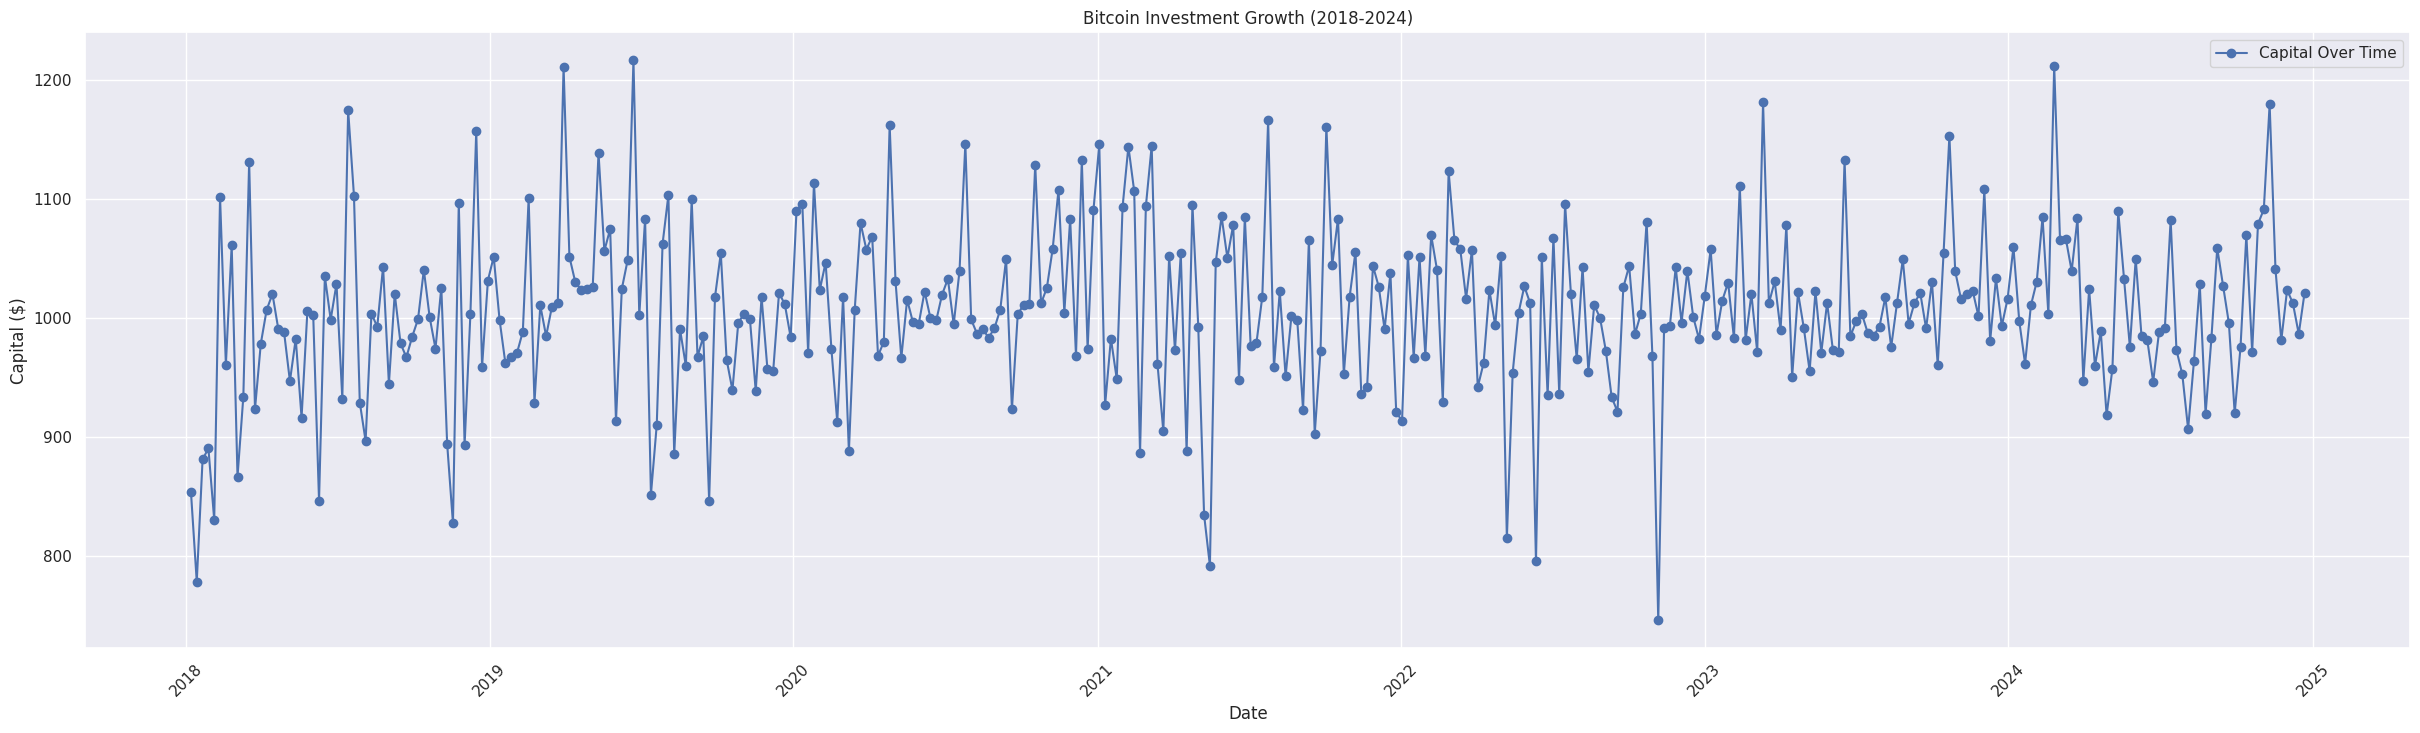

In [203]:
sns.set(style="darkgrid")

open_sun.dropna(subset=['Capital Wed'], inplace=True)

plt.figure(figsize=(30, 8))
plt.plot(open_sun.index, open_sun['Capital Wed'], marker='o', linestyle='-', color='b', label='Capital Over Time')

plt.xlabel("Date")
plt.ylabel("Capital ($)")
plt.title("Bitcoin Investment Growth (2018-2024)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

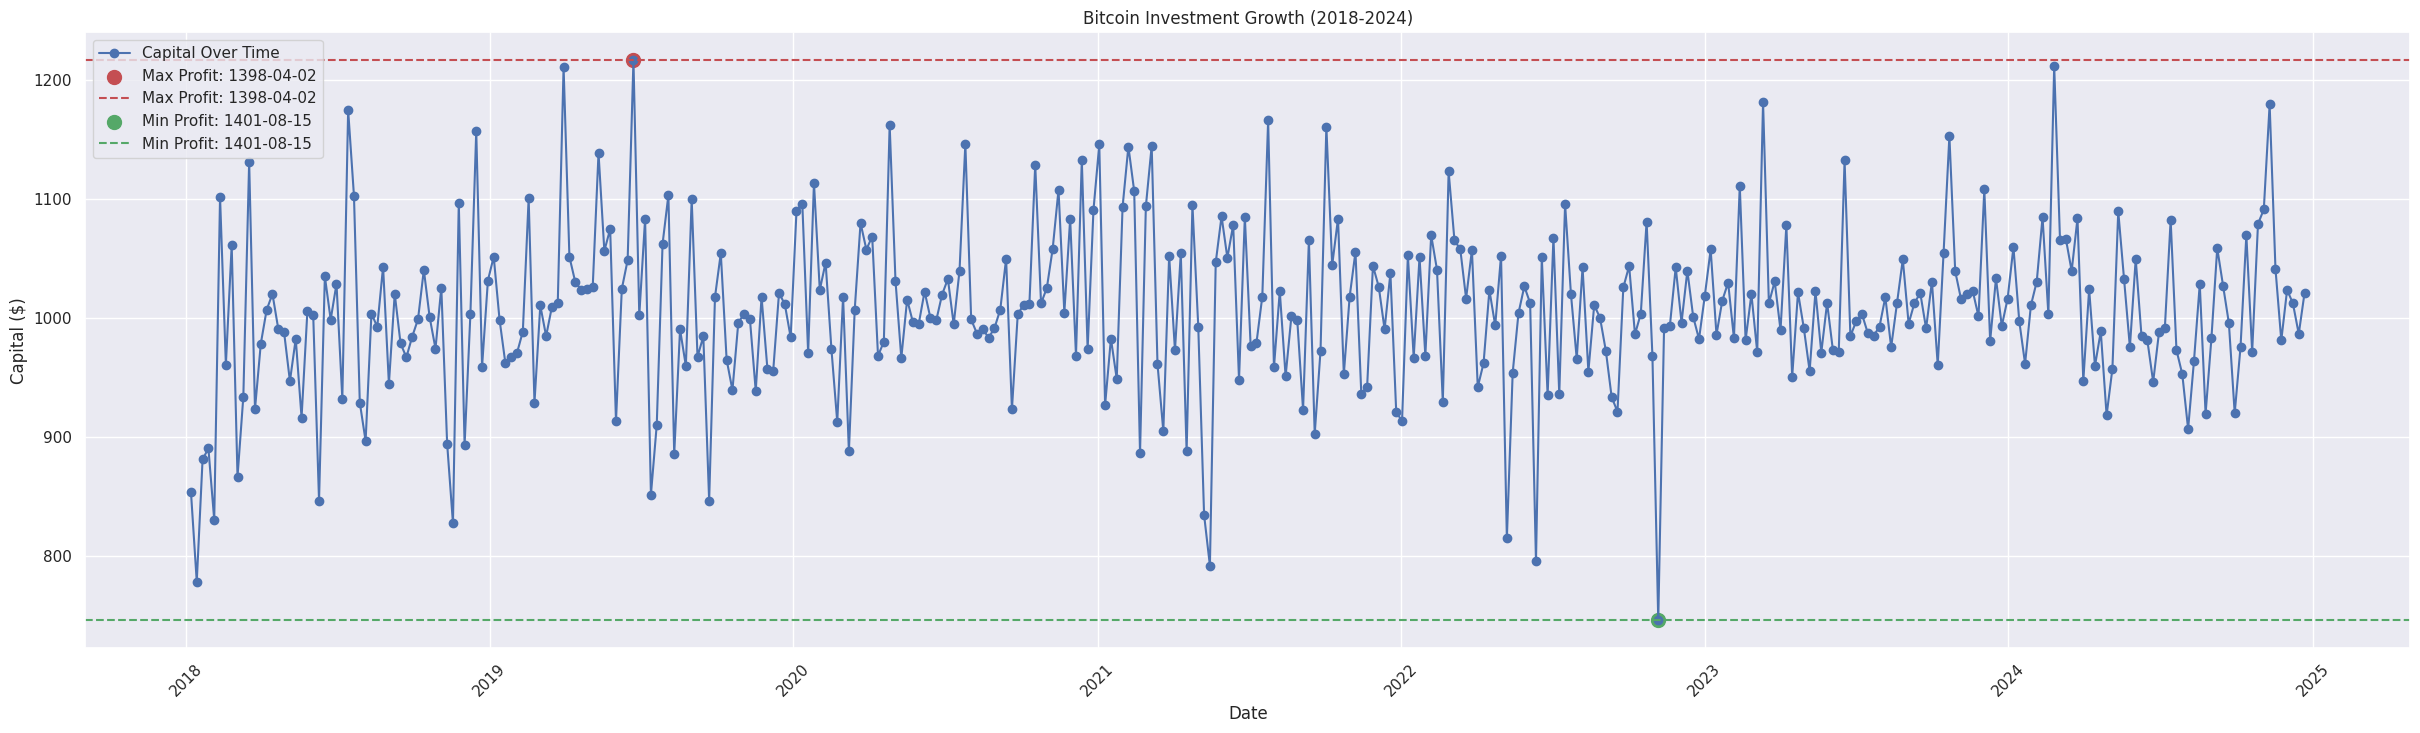

In [204]:
open_sun['Profit/Loss'] = (open_sun['Wednesday Close'] - open_sun['Open']) * open_sun['BTC Purchased']

max_profit_idx = open_sun['Profit/Loss'].idxmax()
max_profit_date = open_sun.loc[max_profit_idx, 'Solar_Date']
max_profit_value = open_sun.loc[max_profit_idx, 'Capital Wed']

min_profit_idx = open_sun['Profit/Loss'].idxmin()
min_profit_date = open_sun.loc[min_profit_idx, 'Solar_Date']
min_profit_value = open_sun.loc[min_profit_idx, 'Capital Wed']

plt.figure(figsize=(30, 8))
plt.plot(open_sun.index, open_sun['Capital Wed'], marker='o', linestyle='-', color='b', label='Capital Over Time')

plt.scatter(open_sun.index[open_sun.index.get_loc(max_profit_idx)], max_profit_value, color='r', s=100, label=f'Max Profit: {max_profit_date}')
plt.axhline(y=max_profit_value, color='r', linestyle='--', label=f'Max Profit: {max_profit_date}')

plt.scatter(open_sun.index[open_sun.index.get_loc(min_profit_idx)], min_profit_value, color='g', s=100, label=f'Min Profit: {min_profit_date}')
plt.axhline(y=min_profit_value, color='g', linestyle='--', label=f'Min Profit: {min_profit_date}')

plt.xlabel("Date")
plt.ylabel("Capital ($)")
plt.title("Bitcoin Investment Growth (2018-2024)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

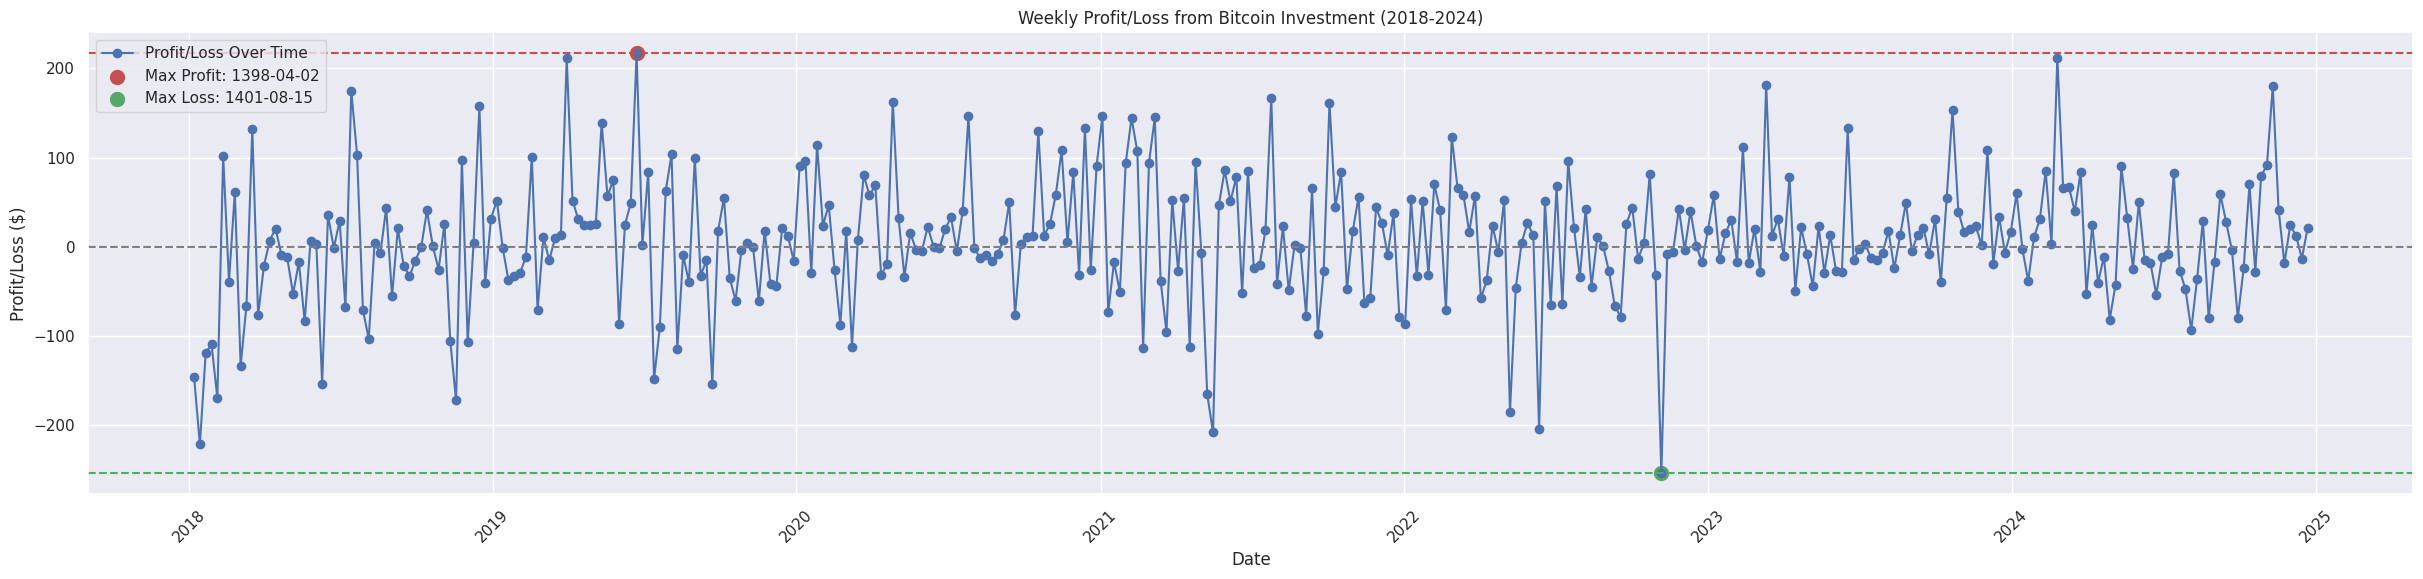

The highest profit occurred in the week of 1398-04-02 with a value of 216.85 USD.
The highest loss occurred in the week of 1401-08-15 with a value of -253.90 USD.


In [206]:
max_loss_idx = open_sun['Profit/Loss'].idxmin()
max_profit_value = open_sun.loc[max_profit_idx, 'Profit/Loss']

max_loss_date = open_sun.loc[max_loss_idx, 'Solar_Date']
max_loss_value = open_sun.loc[max_loss_idx, 'Profit/Loss']

plt.figure(figsize=(30, 6))
plt.plot(open_sun.index, open_sun['Profit/Loss'], marker='o', linestyle='-', color='b', label='Profit/Loss Over Time')

plt.scatter(open_sun.index[open_sun.index.get_loc(max_profit_idx)], max_profit_value, color='r', s=100, label=f'Max Profit: {max_profit_date}')

plt.scatter(open_sun.index[open_sun.index.get_loc(max_loss_idx)], max_loss_value, color='g', s=100, label=f'Max Loss: {max_loss_date}')

plt.axhline(y=max_profit_value, color='r', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=max_loss_value, color='g', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Profit/Loss ($)")
plt.title("Weekly Profit/Loss from Bitcoin Investment (2018-2024)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

print(f"The highest profit occurred in the week of {max_profit_date} with a value of {max_profit_value:.2f} USD.")
print(f"The highest loss occurred in the week of {max_loss_date} with a value of {max_loss_value:.2f} USD.")

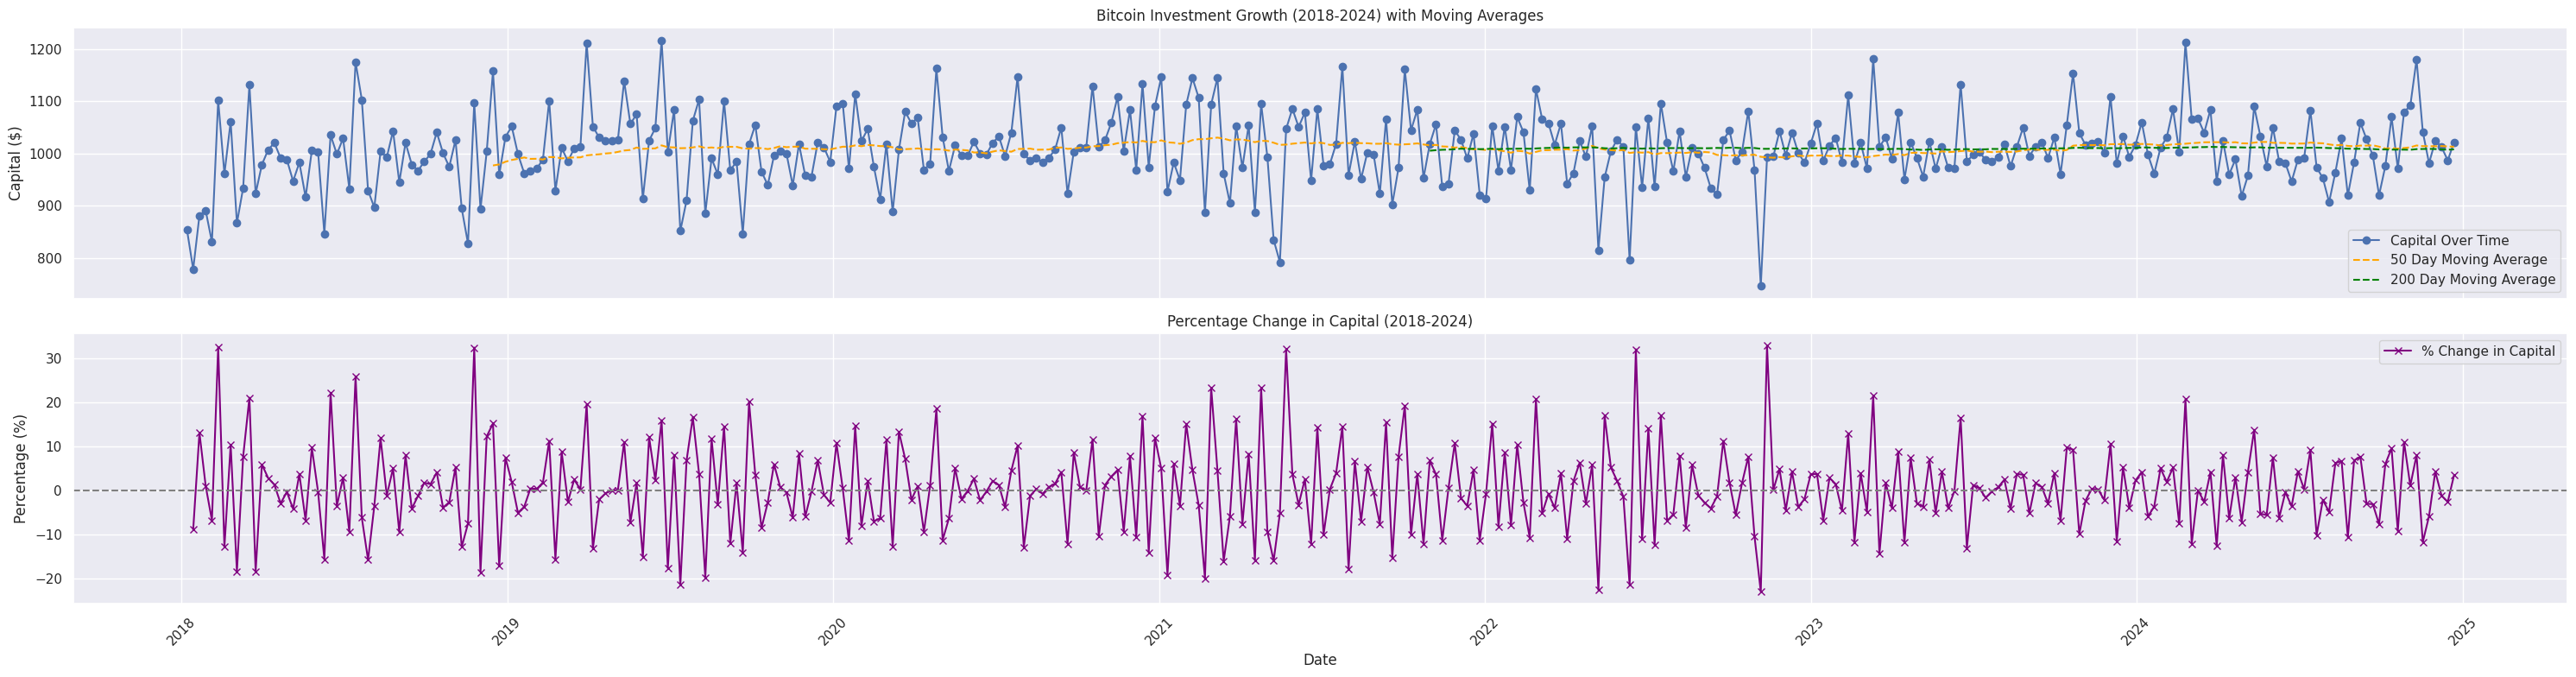

The highest profit occurred on 1398-04-02 with a value of $1216.85.
The highest loss occurred on 1401-08-15 with a value of $746.10.


In [207]:
open_sun['50 Day MA'] = open_sun['Capital Wed'].rolling(window=50).mean()
open_sun['200 Day MA'] = open_sun['Capital Wed'].rolling(window=200).mean()

open_sun['Pct Change'] = open_sun['Capital Wed'].pct_change() * 100

fig, axs = plt.subplots(2, 1, figsize=(30, 8), sharex=True)

axs[0].plot(open_sun.index, open_sun['Capital Wed'], marker='o', linestyle='-', color='b', label='Capital Over Time')
axs[0].plot(open_sun.index, open_sun['50 Day MA'], linestyle='--', color='orange', label='50 Day Moving Average')
axs[0].plot(open_sun.index, open_sun['200 Day MA'], linestyle='--', color='green', label='200 Day Moving Average')
axs[0].set_title("Bitcoin Investment Growth (2018-2024) with Moving Averages")
axs[0].set_ylabel("Capital ($)")
axs[0].legend()

axs[1].plot(open_sun.index, open_sun['Pct Change'], marker='x', linestyle='-', color='purple', label='% Change in Capital')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].set_title("Percentage Change in Capital (2018-2024)")
axs[1].set_ylabel("Percentage (%)")
axs[1].set_xlabel("Date")
axs[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

max_profit_idx = open_sun['Profit/Loss'].idxmax()
max_loss_idx = open_sun['Profit/Loss'].idxmin()

max_profit_value = open_sun['Capital Wed'][max_profit_idx]
max_loss_value = open_sun['Capital Wed'][max_loss_idx]

print(f"The highest profit occurred on {open_sun['Solar_Date'][max_profit_idx]} with a value of ${max_profit_value:.2f}.")
print(f"The highest loss occurred on {open_sun['Solar_Date'][max_loss_idx]} with a value of ${max_loss_value:.2f}.")